**Testing Script: Variable hourly particle input**

Different from the previous version, now a constant hourly release of particles will happen just during a certain amount of time (day, week, month), but the analysis will start after this release.

For example:

- 1st day releasing particles every hour. From the 2nd day, the release stops and the analysis starts from there.

- 1st week releasing particles every hour. From the 2nd week, the release stops and the analysis starts from there.

- 1st month releasing particles every hour. From the 2nd month, the release stops and the analysis starts from there.


In [1]:
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from MODEL_OP_V2 import simulation_run
import useful_params
import mapitas

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
clat = [49.195045]
clon = [-123.301956]
dmin = 60

In [5]:
n=100
length = 2

In [6]:
initial = datetime(2022,1,1)
end = datetime(2022,5,1)
difference = end-initial

In [7]:
n_hourly = int(n/24) # amount of particles released every hour through the day
#
total_hours = length * 24 # total hours through the simulation
#
release_times = [datetime(2022,1,1) + timedelta(hours=h) for h in range(total_hours)] # set the hourly release times
#

In [8]:
aa = np.arange(0,10)
bb = np.arange(10,20)
cc = np.arange(20,30)
z = 70

In [9]:
np.array([aa,bb,cc]).shape

(3, 10)

In [10]:
lon = np.zeros([len(release_times),n_hourly])
lat = np.zeros([len(release_times),n_hourly])
Z = np.zeros([len(release_times),n_hourly])
for i in range(len(release_times)):
    lon[i,:] = clon[0]
    lat[i,:] = clat[0]
    Z[i,:] = z

In [ ]:
lon.shape

(48, 4)

In [12]:
lon = np.repeat(clon[0], total_hours * n_hourly)
lat = np.repeat(clat[0], total_hours * n_hourly)
Z = np.repeat(z, total_hours * n_hourly)
time = np.concatenate([np.repeat(t, n_hourly) for t in release_times])

In [13]:
release_interval = timedelta(hours=1)
total_release_duration = timedelta(days=1)
release_times = [datetime(2022,1,1) + i * release_interval for i in range(int(total_release_duration / release_interval))]
num_releases = len(release_times)

In [14]:
time = [release_time for release_time in release_times for _ in range(n_hourly)]


In [15]:
def simulation_run(start_time, sim_length, number_particles, days_release):
    #
    #
    #### DATA AND OUTPUT PATHS ####
    path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
    'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
    'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
    'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
    'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2',
    'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
    'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
    #
    coords = xr.open_dataset(path['coords'], decode_times=False)
    mask = xr.open_dataset(path['mask'])
    #### Function for getting dates stamps ####
    def get_timestamps(start_time,sim_length):
        timestamps=[]
        duration = timedelta(days=sim_length)
        for day in range(duration.days):
            timestamps.append([start_time + timedelta(days=day)])
        return np.array(timestamps, dtype='datetime64')
    #
    #### Function to get grid point gridX and gridY ####
    path_NEMO = make_prefix(start_time,path['NEMO'])
    jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
    def finder(lati,loni):
        j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
        i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
        return j,i
    #
    #### Setting deploying cordinates ####
    #
    # IONA OUTFALL COORDINATES
    clat = [49.195045]
    clon = [-123.301956]
    z = 70 # 70 m depth
    #
    n_hourly = int(number_particles) # amount of particles released every hour through the day
    #
    release_interval = timedelta(hours=1)
    total_release_duration = timedelta(days=days_release)
    #total_hours = sim_length * 24 # total hours through the simulation
    #repeatdt = timedelta(hours=1) # release n_hourly amount of particles every hour!!!
    #
    release_times = [start_time + i * release_interval for i in range(int(total_release_duration / release_interval))]
    num_releases = len(release_times)
    #release_times = [start_time + timedelta(hours=h) for h in range(total_hours)] # set the hourly release times
    #

    lon = [clon[0]] * num_releases * n_hourly
    lat = [clat[0]] * num_releases * n_hourly
    depth = [z] * num_releases * n_hourly
    time = [release_time for release_time in release_times for _ in range(n_hourly)]
    #lon = clon[0] * np.ones(n_hourly)
    #lat = clat[0] * np.ones(n_hourly)
    #Z =  z * np.ones(n_hourly)
    #time = np.concatenate([np.repeat(t, n_hourly) for t in release_times])
    #
    a, b = finder(clat[0], clon[0])
    print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
    #
    duration = timedelta(days=sim_length) # RUN DURATION IN DAYS
    #
    #x_offset, y_offset, z = p_deploy(N,n_hourly,dmin,dd,rrr)
    #
    #lon = np.zeros([N,n_hourly])
    #lat = np.zeros([N,n_hourly])
    #for i in range(N):
    #    lon[i,:]=(clon[i] + x_offset[i,:])
    #    lat[i,:]=(clat[i] + y_offset[i,:])
    #
    #
    #### Name of the output file #### 
    name_states = 'PBDEs_run_for_'+str(sim_length)+'_days_'+str(n_hourly)+'_hourly_particles_'
    daterange = [start_time+timedelta(days=i) for i in range(sim_length)]
    fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start_time, start_time+duration]) + '.zarr'
    outfile_states = os.path.join(path['out'], fn)
    #
    local = 0
    ####
    ####
    ####
    #### CREATING FIELDSETS ####
    varlist=['U','V','W']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
    field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')
    #
    #Find file names and variable names ###'Diat','Flag'###
    varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
    density = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(density)
    #
    #Add Vertical diffusivity coefficient field
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
    Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(Kz)
    #
    #Add Bathymetry 2D field
    dimensions = {'lon': 'glamt', 'lat': 'gphit'}
    Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(MBATHY)
    field_set.add_field(Bth)
    field_set.add_field(TD)
    #
    #Add SSH 
    dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
    SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(SSH)
    #
    # Add e3t
    varlist = ['cell_size']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
    E3T = Field.from_netcdf(filenames['cell_size'], variables['cell_size'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(E3T)
    ####
    ####
    ####
    #### DEFINE A PARTICLE TYPE AND SET ####
    class MPParticle(JITParticle):    
        n = Variable('n', initial = n_hourly)
        vvl_factor = Variable('fact', initial =  1)    
        wa = Variable('wa', initial =  0) 
        wm = Variable('wm', initial =  0)
        initialized = Variable('initialized', initial = 0)
        status = Variable('status') # different status for different processes
    #
    #pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z, time=start_time+timedelta(hours=odt))
    #
    #pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat,
    #depth=Z, time=time)
    pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat,
    depth=depth, time=time)#, repeatdt=repeatdt)
    
    ####
    ####
    ####
    ####
    ################ KERNELS ###################
    #
    #### States Kernel for particles release ####
    #### Interaction of 3 different states for PBDEs ####
    # 
    def PBDEs_states(particle, fieldset, time):
        if particle.initialized == 0:#particle.time <= 3600
            n = particle.n 
            # n is the total amount of particles released at the starting location
            data = ParcelsRandom.randint(0, n-1)
            #
            # PBDEs as Sewage Particles
            if data < 3*(n/4):
                particle.status = 1
            #
            # Colloidal/Dissolved PBDEs
            else:
                particle.status = 2
            #
            particle.initialized = 1
            #print('Particle Initialized = 0')    
        else: #particle.time > 3600:
            abso = 0.7/(24)#0.038/(24) #per hour
            deso_s = 3.2/(24) #per hour
            deso_m = 1.8/(24)#1.6/(24) #per hour
            #dt_h = 1 / 3600
            dt_h = math.fabs(particle.dt) / 3600
            value = ParcelsRandom.random()# * dt_h
            #
            #value = ParcelsRandom.random() * dt_h
            if particle.status == 2:
                if value < 1 - math.exp(-abso * dt_h):
                    particle.status = 3
               # From Coloidal/Dissolved form to being attached to a Marine Particle           
            elif particle.status == 1:
                if value < 1 - math.exp(-deso_s * dt_h):
                    particle.status = 2
               # From Sewage Particle to Colloidal/Dissolved PBDE form
            elif particle.status == 3:
                if value < 1 - math.exp(-deso_m * dt_h):
                    particle.status = 2
                # From a Marine Particle to a Colloidal/Dissolved form
            #print('Particle Initialized = 1')
            #if particle.status == 1:  # Sewage Particle
            #    if value < 1 - math.exp(-deso_s * dt_h):
            #        particle.status = 2  # Transition to Colloidal/Dissolved PBDEs
            #elif particle.status == 2:  # Colloidal/Dissolved PBDEs
            #    if value < 1 - math.exp(-abso * dt_h):
            #        particle.status = 3  # Transition to Marine Particle
            #elif particle.status == 3:  # Marine Particle
            #    if value < 1 - math.exp(-deso_m * dt_h):
            #        particle.status = 2  # Transition back to Colloidal/Dissolved PBDEs    
       
    #
    #### PBDEs states sinking velocities features ####
    def PBDEs_forms(particle, fieldset, time):
        #
        #dt_h = 1 / 3600
        dt_h = math.fabs(particle.dt) / 3600
        if particle.status == 1:
            sinkvel = 50*(dt_h) # m/hr * dt --> to seconds
            particle.depth += sinkvel * particle.dt
        #Sewage Particles sink fast        
        elif particle.status == 2:
            sinkvel = 0.0
            particle.depth += sinkvel * particle.dt
        # Colloids just float around and move with advection
        elif particle.status == 3:
            sinkvel = 10*(dt_h) # m/hr * dt --> to seconds
            particle.depth += sinkvel * particle.dt 
        # Marine Particles sink at a slower rate than sewage particles
        #if particle.status == 1:  # Sewage Particles
        #    sinkvel = 3600 / 3600  #to m/s
        #    particle.depth += sinkvel * particle.dt
        #elif particle.status == 2:  # Colloidal/Dissolved PBDEs
        #    sinkvel = 0.0  # No sinking
        #    particle.depth += sinkvel * particle.dt
        #elif particle.status == 3:  # Marine Particles
        #    sinkvel = 1000 / 3600  #to m/s
        #    particle.depth += sinkvel * particle.dt
    #
    #### ADVECTION ####
    def Advection(particle, fieldset, time): 
        # Advection for all PBDEs in status 1, 2 and 3
        if particle.status == 1 or particle.status == 2 or particle.status == 3: 
            ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
            sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
            td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
            particle.fact = (1+ssh/td)
            VVL = (sshn-ssh)*particle.depth/(td)
            #VVL = (sshn-ssh)*particle.depth/(td+ssh)
            (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
            lon1 = particle.lon + u1*.5*particle.dt
            lat1 = particle.lat + v1*.5*particle.dt
            dep1 = particle.depth + w1*.5*particle.dt/particle.fact
            (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
            lon2 = particle.lon + u2*.5*particle.dt
            lat2 = particle.lat + v2*.5*particle.dt
            dep2 = particle.depth + w2*.5*particle.dt/particle.fact
            (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
            lon3 = particle.lon + u3*particle.dt
            lat3 = particle.lat + v3*particle.dt
            dep3 = particle.depth + w3*particle.dt/particle.fact
            (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
            wa = (w1 + 2*w2 + 2*w3 + w4) /6.
            particle.wa = wa* particle.dt
            particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            particle_ddepth = particle.wa/particle.fact + VVL
            if particle_ddepth + particle.depth < 0:
                particle_ddepth = - (2*particle.depth+particle_ddepth)
#        else:
#            particle_dlon = 0
#            particle_dlat = 0
#            particle_ddepth = 0     
    #
    #### TURBULENT MIX ####
    def turb_mix(particle,fieldset,time):
        if particle.status == 1 or particle.status == 2 or particle.status == 3:
            """Vertical mixing"""
            #Vertical mixing
            if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
                Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
            else: 
                Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
            dgrad = Kzdz*particle.dt/particle.fact
            if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
                Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
            else:
                Kz = 0 
            #
            Rr = ParcelsRandom.uniform(-1, 1)
            d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
            dzs = (dgrad + d_random)
            particle.wm = dzs*particle.fact
    #
    #### VERTICAL DISPLACEMENT ####
    def Displacement(particle,fieldset,time):
        if particle.status == 1 or particle.status == 2 or particle.status == 3:
            #Apply turbulent mixing.
            if dzs + particle_ddepth + particle.depth > td:
                particle.depth  = td # Get particles attached to the bottom when they reach it
                particle.status = 4
            #
            elif dzs + particle.depth+ particle_ddepth < 0:
                particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
            #
            else:
                particle_ddepth += dzs #apply mixing
    #
    #### RESUSPENSION ####
    def resuspension(particle, fieldset, time):
        if particle.status == 4:
            threshold = 1 # threshold for particles to know when to resuspend
            # Calculation of U_star, which is proportional to the bottom stress (tau)
            k = 0.42
            z_star = 0.07
            u_horizontal = (1/4) * (fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon -1]) ** 2
            v_horizontal = (1/4) * (fieldset.V[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat - 1, particle.lon]) ** 2
            vel_horizontal = (u_horizontal + v_horizontal) ** (1/2)
            #
            u_star = (vel_horizontal * k) / ((math.log(fieldset.e3t[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] -1, particle.lat, particle.lon] / 2) / z_star))
            # Here tau is the bottom friction parameter estimated from (u_starr)^2 x density
            tau = ((u_star) ** 2) * 1024
            #
            #
            if tau >= threshold: # for colloids and marine particles
                frac_value = ParcelsRandom.randint(0,10)
                if frac_value >= 3:
                    particle.status = 2
                else:
                    particle.status = 3    
            #    
            else:  # for particles staying at the bottom
                particle.status = 4
    #
    #### OTHERS ####
    def export(particle,fieldset,time):
        if particle.lat<48.7 and particle.lon < -124.66:
            particle.status = 7
    #
    def CheckOutOfBounds(particle, fieldset, time):
        if particle.state == StatusCode.ErrorOutOfBounds:    
            particle.delete()
    #        
    def KeepInOcean(particle, fieldset, time):
        if particle.state == StatusCode.ErrorThroughSurface:
            particle.depth = 0.0
            particle.state = StatusCode.Success             
    ##########################################################
    #
    #
    runtime = duration  # Total simulation runtime
    dt = 20     # Simulation timestep in seconds
    output_interval = timedelta(hours=1)
    output_file = pset_states.ParticleFile(name=outfile_states, outputdt=output_interval)
    kernels = [PBDEs_states, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean]
    #
    #
    pset_states.execute(kernels,
            runtime=runtime,
            dt=dt,
            output_file=output_file)

    #
    return outfile_states

In [16]:
#file_name_1week_1day = simulation_run(datetime(2022,1,1), 7, 15, 1)
file_name_1week_1day = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_7_days_15_hourly_particles_20220101_1n_20220108_1n.zarr' 
# simulation starts on the 1st of January 2022, 7 days long with 15 particles being release hourly for just 1 day

In [17]:
#file_name_1month_1week = simulation_run(datetime(2022,1,1), 30, 15, 7) 
# simulation starts on the 1st of January 2022, 30 days long with 15 particles being release hourly for just 1 week

In [18]:
#file_name_1year_1month = simulation_run(datetime(2022,1,1), 365, 15, 30) 
# simulation starts on the 1st of January 2022, 365 days long with 15 particles being release hourly for just 1 month

In [19]:
data = xr.open_zarr(file_name_1week_1day)
depth = data.z/data.fact

In [20]:
data_PBDE = pd.read_excel('/ocean/vvalenzuela/MOAD/analysis-vicente/PBDEs_DATA/predicted_discharges.xlsx')
data_PBDE = data_PBDE.set_index(data_PBDE['Unnamed: 0'].values)
data_PBDE.drop('Unnamed: 0', axis=1, inplace=True)
#
PBDE_hourly = data_PBDE.resample('H').interpolate()
PBDE_daily = data_PBDE.copy()

In [35]:
PBDE_daily['PBDE 99'].max()

14.96947295383017

Text(0.5, 1.0, 'PBDE 99')

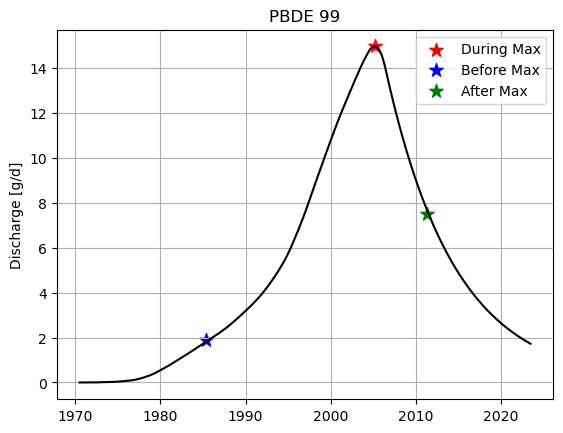

In [81]:
plt.plot(PBDE_daily['PBDE 99'], 'k')
plt.scatter(PBDE_daily['PBDE 99'].idxmax(), PBDE_daily['PBDE 99'].max(), c = 'r', marker = '*', s = 100, label = 'During Max')
plt.scatter(5600, PBDE_daily['PBDE 99'].max()/8, c = 'b', marker = '*', s = 100, label = 'Before Max')
plt.scatter(15100, PBDE_daily['PBDE 99'].max()/2, c = 'g', marker = '*', s = 100, label = 'After Max')
plt.legend()
plt.grid()
plt.ylabel('Discharge [g/d]')
plt.title('PBDE 99')

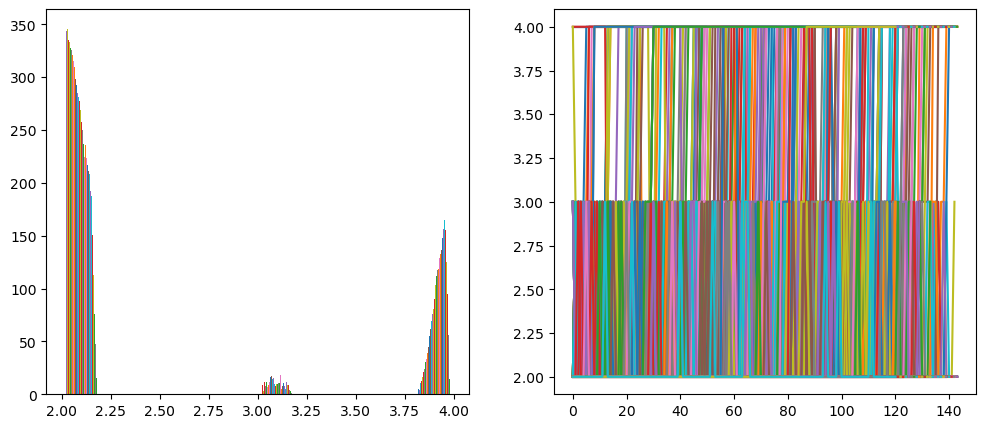

In [22]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].hist(data.status[:,24:])
ax[1].plot(data.status[:,24:].T)

Text(0, 0.5, 'Latitude')

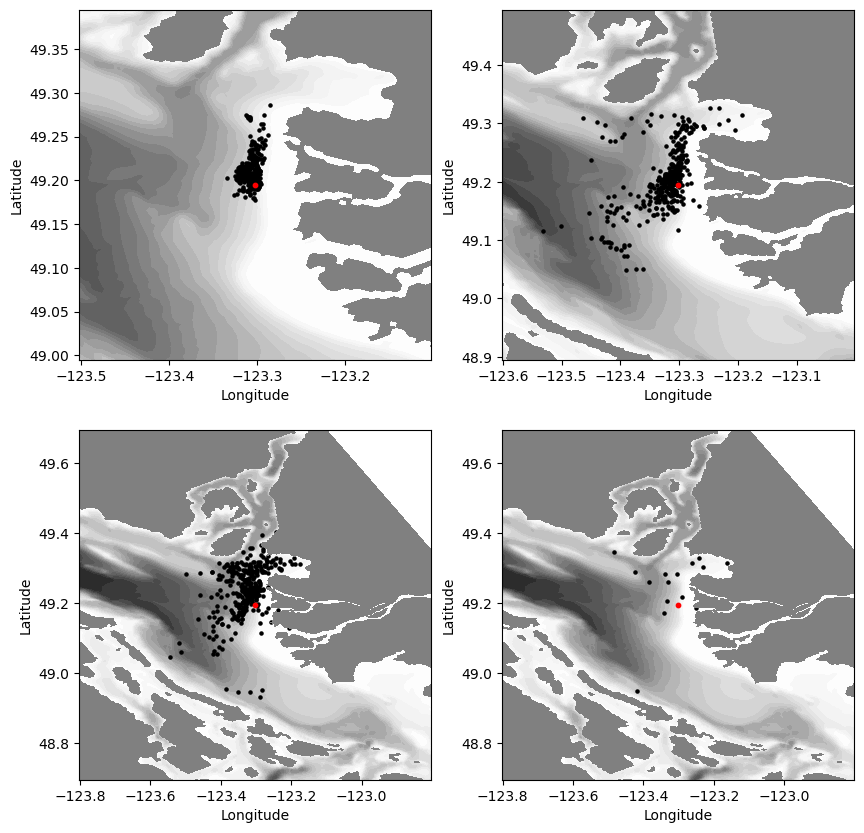

In [92]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
tt_1 = 23
tt_2 = 80
tt_3 = 120
tt_4 = 167
#dt=10
#tt = 30
blevels = list(np.arange(0,500,20))
im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,0].scatter(data.lon[:,tt_1], data.lat[:,tt_1], c = 'k', s = 5)
axs[0,0].scatter(clon[0], clat[0], c = 'r', s = 10)
axs[0,0].set_ylim([clat[0]-0.2,clat[0]+0.2])
axs[0,0].set_xlim([clon[0]-0.2,clon[0]+0.2])
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
#
im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(data.lon[:,tt_2], data.lat[:,tt_2], c = 'k', s = 5)
axs[0,1].scatter(clon[0], clat[0], c = 'r', s = 10)
axs[0,1].set_ylim([clat[0]-0.3,clat[0]+0.3])
axs[0,1].set_xlim([clon[0]-0.3,clon[0]+0.3])
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')
#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(data.lon[:,tt_3], data.lat[:,tt_3], c = 'k', s = 5)
axs[1,0].scatter(clon[0], clat[0], c = 'r', s = 10)
axs[1,0].set_ylim([clat[0]-0.5,clat[0]+0.5])
axs[1,0].set_xlim([clon[0]-0.5,clon[0]+0.5])
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
im=axs[1,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs[1,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,1].scatter(data.lon[:,tt_4], data.lat[:,tt_4], c = 'k', s = 5)
axs[1,1].scatter(clon[0], clat[0], c = 'r', s = 10)
axs[1,1].set_ylim([clat[0]-0.5,clat[0]+0.5])
axs[1,1].set_xlim([clon[0]-0.5,clon[0]+0.5])
axs[1,1].set_xlabel('Longitude')
axs[1,1].set_ylabel('Latitude')

Text(0, 0.5, 'Latitude')

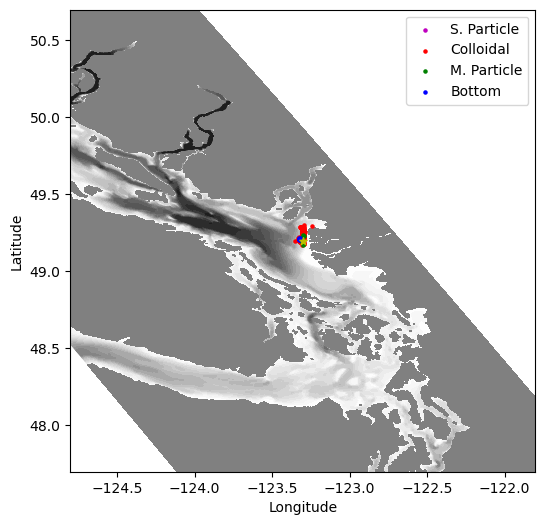

In [24]:
fig,axs=plt.subplots(figsize=(6,6))
#
tt = 30
#
# Make map
blevels = list(np.arange(0,500,20))
im=axs.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap = 'Greys',levels=blevels)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 1),data.lat[:,tt].where(data.status[:,tt] == 1),zorder=3,c='m',s=5, label = 'S. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 2),data.lat[:,tt].where(data.status[:,tt] == 2),zorder=3,c='r',s=5, label = 'Colloidal')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 3),data.lat[:,tt].where(data.status[:,tt] == 3),zorder=3,c='g',s=5, label = 'M. Particle')
axs.scatter(data.lon[:,tt].where(data.status[:,tt] == 4),data.lat[:,tt].where(data.status[:,tt] == 4),zorder=3,c='b',s=5, label = 'Bottom')
#
axs.legend()
axs.scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
axs.set_ylim([clat[0]-1.5,clat[0]+1.5])
axs.set_xlim([clon[0]-1.5,clon[0]+1.5])
#axs[0].set_title(f'Final Particles position during '+ str(date_jan_end))
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

In [22]:
import useful_params
import mapitas

In [ ]:
cat = ['S.Particles', 'Colloidal', 'M. Particles', 'Bottom']
aa_in, aa_fin, aa = useful_params.percentages(file_name_1week_1day)
propor = useful_params.proportions(file_name_1week_1day)*100

In [ ]:
fig = plt.figure(figsize = (18,10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.bar(cat, aa_in)
ax1.set_title('Initial Proportion of PBDEs')
ax1.set_ylabel('Proportion (%)')
ax2.bar(cat, aa)
ax2.set_title('Total Proportion of PBDEs throughout Simulation')
ax2.set_ylabel('Proportion (%)')
ax3.bar(cat, aa_fin)
ax3.set_title('Final Proportion of PBDEs')
ax3.set_ylabel('Proportion (%)')
#
ax4 = fig.add_subplot(gs[1, :])

ax4.plot(propor['Sewage'], 'b', label = 'S. Particle')
ax4.plot(propor['Colloidal'], 'r', label = 'Colloidal')
ax4.plot(propor['Marine'], 'g', label = 'M. Particle')
ax4.plot(propor['Bottom'], 'k', label = 'At Bottom')
ax4.set_ylabel('Proportion between PBDEs Phases (%)')
ax4.set_xlabel('Time (through simulation)')
ax4.legend()
ax4.grid(linestyle = '--', alpha = 0.5)
#ax.set_title('Particle status proportion between ' + str(date_jan_start) + ' and ' + str(date_jan_end))
ax4.set_ylim(0,100)